How to use:
- Pareto: Load the .csv file, transfer in this cwd, and let run
- Models: Adapt odt and save! then let run here -> No Friedman Test for that so far implemented!
- To get only ranks table, return ranked_df in do_ranking

In [1]:
import pandas as pd
from scipy.stats import friedmanchisquare

In [2]:
# Method to Create Average rank of an df with 'dataset_name', 'classifier_name', accuracy
# The higher the accuracy, the better the rank!

def do_ranking(melted_df):

    def rank_accuracies(group):
        # Sort by accuracy
        sorted_group = group.sort_values('accuracy')
        # Compute ranks
        sorted_group['rank'] = sorted_group['accuracy'].rank(method='average')
        return sorted_group

    # Apply ranking within each dataset_name
    ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)
    print('...........')
    #print(ranked_df)

    # Compute average rank per classifier
    average_rank_per_classifier = ranked_df.copy().groupby('classifier_name')['rank'].mean().reset_index()
    average_rank_per_classifier = average_rank_per_classifier.sort_values(by='rank', ascending=True).reset_index(drop=True)

    # Extract lists
    classifier_names = average_rank_per_classifier['classifier_name'].tolist()
    average_ranks = average_rank_per_classifier['rank'].tolist()

    # Display the lists
    print("Classifier Names:", classifier_names)
    print("Average Ranks:", average_ranks)

    # Return the DataFrame sorted by average rank
    return average_rank_per_classifier, classifier_names, average_ranks, ranked_df


In [3]:
def perform_friedman_test(df, alpha=0.05):
    """
    Perform the Friedman test to compare classifiers based on accuracy.

    Parameters:
    df (pd.DataFrame): DataFrame with columns 'classifier_name', 'dataset_name', and 'accuracy'.
    alpha (float): Significance level for the test. Default is 0.05.

    Returns:
    None: Prints the Friedman test results and interpretation.
    """
    # Pivot the DataFrame to have each dataset as rows and classifiers as columns
    df_pivot = df.pivot_table(index='dataset_name', columns='classifier_name', values='accuracy')

    # Drop any rows with NaN values (if there are any datasets without all classifiers)
    df_pivot = df_pivot.dropna()

    # Check the reshaped DataFrame
    print(df_pivot)

    # Perform the Friedman test
    classifiers = df_pivot.columns
    if len(classifiers) < 2:
        raise ValueError("At least two classifiers are required to perform the Friedman test.")
    
    # Extract accuracy values for each classifier
    test_args = [df_pivot[classifier] for classifier in classifiers]
    stat, p_value = friedmanchisquare(*test_args)

    # Print the Friedman test statistic and p-value
    print(f'Friedman test statistic: {stat}')
    print(f'p-value: {p_value}')

    # Interpret the result
    if p_value < alpha:
        print(f'There is a significant difference between the classifiers (alpha = {alpha}).')
    else:
        print(f'There is no significant difference between the classifiers (alpha = {alpha}).')

In [37]:
# Pre loaded Datasets of the pareto values in the proper form

#path = 'rmse_FLAML Results_count_df.csv' # dwt, dft close and no critical difference
#path = 'msmape_FLAML Results_count_df.csv' # dwt winner
#path = 'rmse_Agluon Results_count_df.csv'
#path = 'msmape_Agluon Results_count_df.csv' 

path = 'mape_FLAML Results_count_df.csv' # dwt winner
#path = 'mape_Agluon Results_count_df.csv'


df_perf = pd.read_csv(path, index_col=False)

# do_ranking ranks after lower values! lower error!
df_perf['accuracy'] = df_perf['accuracy'] * -1

print(df_perf)
ranked , classifiers, average_ranks, ranked_df = do_ranking(df_perf)


   classifier_name                dataset_name  accuracy
0              dwt        BenzeneConcentration        -5
1              dft        BenzeneConcentration        -2
2              dct        BenzeneConcentration        -2
3              dwt          BeijingPM25Quality        -5
4              dft          BeijingPM25Quality        -4
5              dct          BeijingPM25Quality        -3
6              dwt              FloodModeling1        -6
7              dft              FloodModeling1        -1
8              dct              FloodModeling1         0
9              dwt          BeijingPM10Quality        -3
10             dft          BeijingPM10Quality        -4
11             dct          BeijingPM10Quality        -1
12             dwt  HouseholdPowerConsumption1        -2
13             dft  HouseholdPowerConsumption1        -2
14             dct  HouseholdPowerConsumption1         0
15             dwt                     IEEEPPG        -1
16             dft             

/tmp/ipykernel_14013/3430632323.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)


In [38]:
perform_friedman_test(df_perf, 0.05)

classifier_name             dct  dft  dwt
dataset_name                             
AppliancesEnergy           -1.0 -2.0 -4.0
BeijingPM10Quality         -1.0 -4.0 -3.0
BeijingPM25Quality         -3.0 -4.0 -5.0
BenzeneConcentration       -2.0 -2.0 -5.0
Covid3Month                 0.0 -1.0  0.0
FloodModeling1              0.0 -1.0 -6.0
HouseholdPowerConsumption1  0.0 -2.0 -2.0
IEEEPPG                     0.0 -1.0 -1.0
Friedman test statistic: 10.785714285714286
p-value: 0.004548957728782791
There is a significant difference between the classifiers (alpha = 0.05).


1.0261465


/tmp/ipykernel_14013/4002276892.py:16: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, num_ds , alpha='0.1', test=test)
/tmp/ipykernel_14013/4002276892.py:18: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=10, textspace=2.5, filename='autoMLcomparision.pdf')


1.0261465

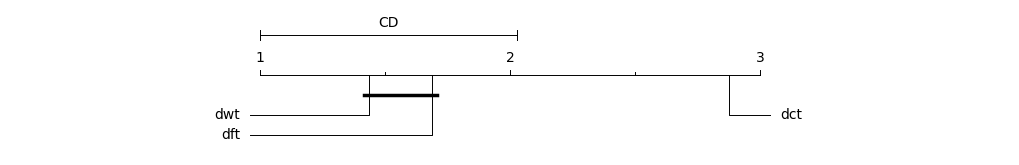

In [39]:
# Create the Cd-Diagram
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

names = classifiers
avranks = average_ranks

test = 'nemenyi'
#test = 'bonferroni-dunn'

# always 8 for me!
num_ds = 8
#num_ds = 11

cd = scoring.compute_CD(avranks, num_ds , alpha='0.1', test=test) 
print(cd)
scoring.graph_ranks(avranks, names, cd, width=10, textspace=2.5, filename='autoMLcomparision.pdf')
cd

In [12]:
# Load the values form ods file

pd.set_option('display.max_rows', None)
# Load the ODS file
file_path = '/home/sim/Desktop/TS Extrinsic Regression/AutoML-Results.ods'
result_df = pd.read_excel(file_path, engine='odf', sheet_name='result')

# Transform the DataFrame to have classifier names as a single column
melted_df = result_df.melt(id_vars=['Dataset Name'], var_name='classifier_name', value_name='accuracy')

# Rename columns to match the desired output
melted_df = melted_df.rename(columns={'Dataset Name': 'dataset_name'})

# Drop any rows where accuracy is NaN
melted_df = melted_df.dropna(subset=['accuracy'])

# Now melted_df contains the required data
#print(melted_df)


ranked, classifiers, average_ranks, ranked_df = do_ranking(melted_df.copy())

ranked_df


for i in range(len(classifiers)):
    print(classifiers[i], average_ranks[i])



...........
Classifier Names: ['AutoGluon', 'Rocket', 'XGBoost', 'Random Forest', 'Inception', 'FCN', 'FLAML', 'ResNet', 'FPCR', 'FPCR-Bspline', 'SVR Optimised', 'SVR']
Average Ranks: [4.125, 4.875, 4.875, 5.125, 5.5, 6.0, 6.375, 6.75, 7.5625, 7.6875, 8.9375, 10.1875]
AutoGluon 4.125
Rocket 4.875
XGBoost 4.875
Random Forest 5.125
Inception 5.5
FCN 6.0
FLAML 6.375
ResNet 6.75
FPCR 7.5625
FPCR-Bspline 7.6875
SVR Optimised 8.9375
SVR 10.1875


/tmp/ipykernel_12865/3430632323.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)


In [5]:
# Friedman on performance: include the ranks in my code!
ranked_df.drop('accuracy', axis=1)
ranked_df.rename(columns={'accuracy':'rank'})

perform_friedman_test(melted_df, 0.05)

classifier_name              AutoGluon         FCN       FLAML        FPCR  \
dataset_name                                                                 
AppliancesEnergy              2.155978    2.865684    2.516904    5.405052   
BeijingPM10Quality           108.25219   94.348729  108.381598   99.725946   
BeijingPM25Quality           75.187533   59.726847   76.546076   69.379217   
BenzeneConcentration          3.874767    4.988295    4.001022   11.088396   
Covid3Month                   0.040439     0.07434    0.043481    0.044912   
FloodModeling1                 0.01368    0.006709    0.016977    0.018853   
HouseholdPowerConsumption1  145.957598  162.244492   169.33506  147.548998   
IEEEPPG                      25.574776   34.325728   27.603676   31.381214   

classifier_name            FPCR-Bspline   Inception Random Forest      ResNet  \
dataset_name                                                                    
AppliancesEnergy               5.405052     4.43533      

For RQ1: Nemyi

5.891477995210709


/tmp/ipykernel_14013/1019123395.py:16: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks, num_ds , alpha='0.05', test=test)
/tmp/ipykernel_14013/1019123395.py:18: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=10, textspace=2.5, filename='autoMLcomparision.pdf')


5.891477995210709

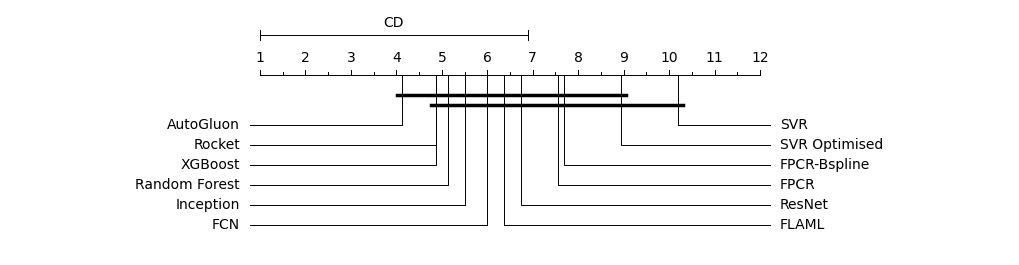

In [33]:
# Create the Cd-Diagram
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

names = classifiers
avranks = average_ranks

test = 'nemenyi'
#test = 'bonferroni-dunn'

# always 8 for me!
num_ds = 8
#num_ds = 11

cd = scoring.compute_CD(avranks, num_ds , alpha='0.05', test=test) 
print(cd)
scoring.graph_ranks(avranks, names, cd, width=10, textspace=2.5, filename='autoMLcomparision.pdf')
cd